In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [ ]:
# Import Libraries
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np# Keras API
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics

**Load** **Data**

In [ ]:
train_path = '/content/drive/My Drive/Colab Notebooks/training'
val_path = '/content/drive/My Drive/Colab Notebooks/validation'
test_path = '/content/drive/My Drive/Colab Notebooks/testing'

**Function to Get count of images in train and test data**

In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0

  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

**View Number of Images**

In [ ]:
train_samples = get_files(train_path)
num_classes = len(glob.glob(train_path+"/*"))
test_samples = get_files(test_path)
val_samples = get_files(val_path)

print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")
print(val_samples, "Validation images")

10 Classes
1750 Train images
500 Test images
250 Validation images


**Data Preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   #validation_split=0.2, # validation split 20%.
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
img_width, img_height = 256, 256
input_shape = (img_width, img_height, 3)
batch_size = 32

train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size = (img_width, img_height),
                                                   batch_size = batch_size)
test_generator = test_datagen.flow_from_directory(test_path, shuffle = False,
                                                   target_size = (img_width, img_height),
                                                   batch_size = batch_size)
val_generator = val_datagen.flow_from_directory(val_path, shuffle = False,
                                                   target_size = (img_width, img_height),
                                                   batch_size = batch_size)

Found 1750 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 250 images belonging to 10 classes.


**Get name of the plant disease**

In [ ]:
train_generator.class_indices

{'Bacteria_spot': 0,
 'Early_blight': 1,
 'Healthy': 2,
 'Late_blight': 3,
 'Leaf_mold': 4,
 'Mosaic_virus': 5,
 'Septoria_leaf_spot': 6,
 'Spider_mites': 7,
 'Target_spot': 8,
 'Yellow_leaf_curl': 9}

**Build CNN Parameters**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 41, 41, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 64)        0

**Get names of layers**

In [ ]:
model_layers = [ layer.name for layer in model.layers]
print('layer name : ',model_layers)

layer name :  ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'flatten', 'dense', 'dropout', 'dense_1', 'dense_2']


**Training the CNN Model**

In [ ]:
# validation data.
validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (img_height, img_width),
    batch_size = batch_size)

Found 250 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model with the specified optimizer, loss, and metrics
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 6,
    restore_best_weights = True)

model_checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/best_tomato_disease_model.h5',
    monitor = 'val_accuracy',
    save_best_only = True)

# Train the model with the specified callbacks
train = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    verbose = 1,
    epochs = 50,
    callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 2.0396 - accuracy: 0.2440 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 935s 17s/step - loss: 2.0396 - accuracy: 0.2440 - val_loss: 1.7907 - val_accuracy: 0.3560
Epoch 2/50
55/55 [==============================] - 36s 653ms/step - loss: 1.6454 - accuracy: 0.4063 - val_loss: 1.6887 - val_accuracy: 0.4200
Epoch 3/50
55/55 [==============================] - 35s 630ms/step - loss: 1.2781 - accuracy: 0.5463 - val_loss: 1.8816 - val_accuracy: 0.5000
Epoch 4/50
55/55 [==============================] - 37s 671ms/step - loss: 1.1080 - accuracy: 0.5971 - val_loss: 1.5979 - val_accuracy: 0.5040
Epoch 5/50
55/55 [==============================] - 36s 654ms/step - loss: 0.9721 - accuracy: 0.6554 - val_loss: 1.4773 - val_accuracy: 0.5760
Epoch 6/50
55/55 [==============================] - 36s 656ms/step - loss: 0.9070 - accuracy: 0.6846 - val_loss: 1.0317 - val_accuracy: 0.6520
Epoch 7/50
55/55 [==============================] - 34s 624ms/step - loss: 0.7221 - accuracy: 0.7514 - val_loss: 1.5478 - val_accuracy: 0.5840
Epoch 8/50


**Plot Accuracy and Losses**

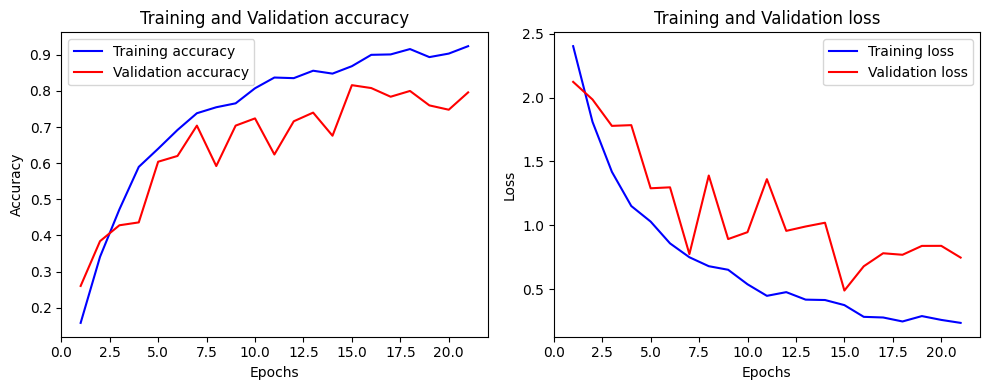

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history object already available
acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation loss
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust the layout for better appearance
plt.show()

**Load Model**

In [ ]:
# Loading model and predict
from keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/best_tomato_disease_model.h5')

**Evaluate Model**

In [ ]:
score, accuracy = model.evaluate(validation_generator, verbose = 1)
print("Validation score is {:.2f}%".format(score*100))
print("Validation accuracy is {:.2f}%".format(accuracy*100))

8/8 [==============================] - 1s 120ms/step - loss: 0.5879 - accuracy: 0.8080
Validation score is 58.79%
Validation accuracy is 80.80%


In [ ]:
# Get classes of model trained on
classes = train_generator.class_indices
classes

{'Bacteria_spot': 0,
 'Early_blight': 1,
 'Healthy': 2,
 'Late_blight': 3,
 'Leaf_mold': 4,
 'Mosaic_virus': 5,
 'Septoria_leaf_spot': 6,
 'Spider_mites': 7,
 'Target_spot': 8,
 'Yellow_leaf_curl': 9}

In [ ]:
Classes = ['Bacteria_spot','Early_blight','Healthy','Late_blight','Leaf_mold','Mosaic_virus','Septoria_leaf_spot','Spider_mites','Target_spot','Yellow_leaf_curl']

1/1 [==============================] - 0s 23ms/step


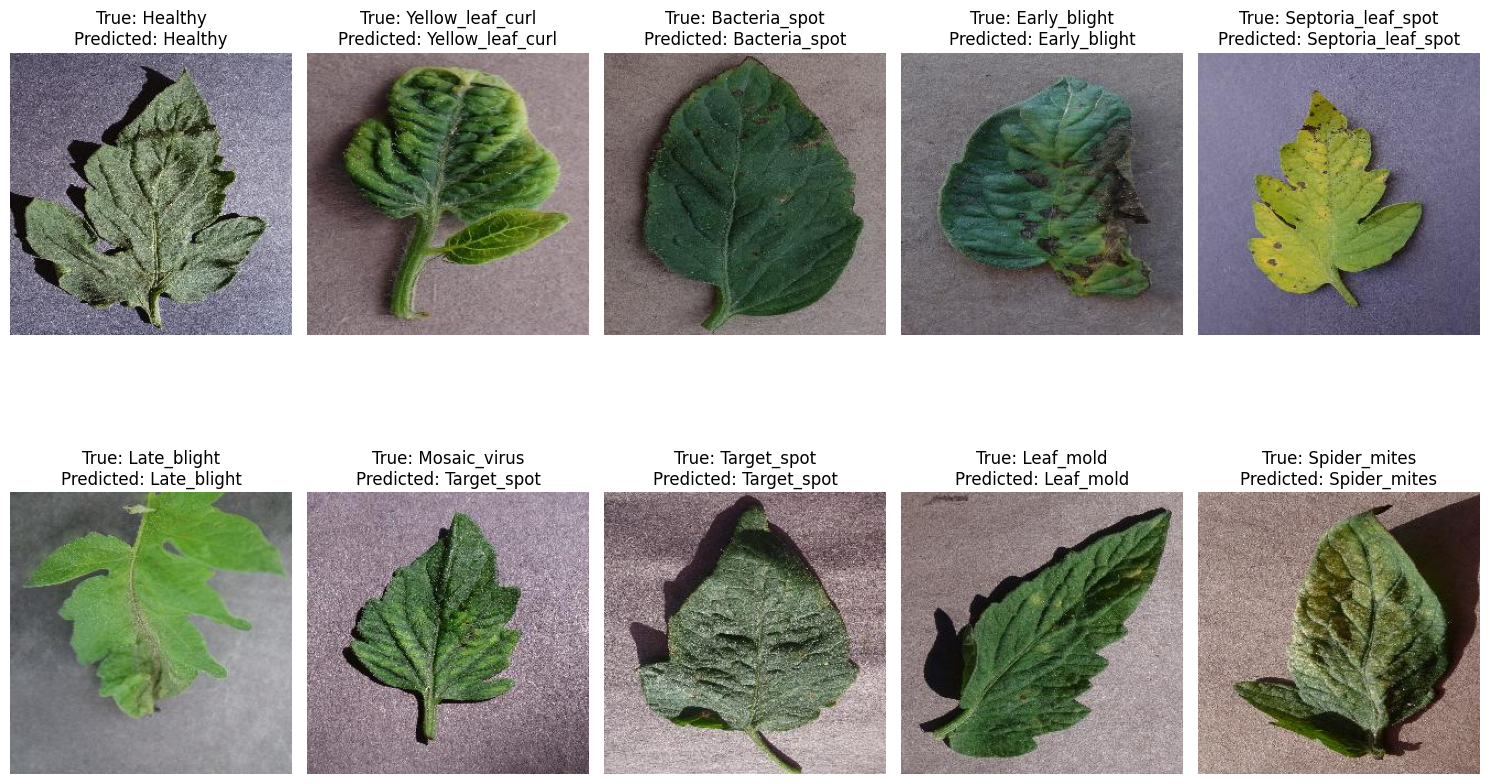

In [ ]:
import os
import random
from keras.preprocessing import image

# Path to the testing directory
test_dir = '/content/drive/My Drive/Colab Notebooks/testing/'

# Get a list of all subdirectories (each subdirectory represents a disease class)
disease_classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

# Randomly select 10 images from the testing set
selected_images = random.sample(disease_classes, 10)

# Display the images and their predictions
plt.figure(figsize=(15, 10))

for i, disease_class in enumerate(selected_images, 1):
    # Randomly select an image from the chosen disease class
    images_in_class = os.listdir(os.path.join(test_dir, disease_class))
    img_name = random.choice(images_in_class)
    img_path = os.path.join(test_dir, disease_class, img_name)

    # Pre-process the image
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = x / 255.0  # Normalize
    x = np.expand_dims(x, axis=0)

    # Predict the disease
    result = model.predict(x)
    predicted_class = Classes[np.argmax(result)]

    # Display the image and its predicted class
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(f"True: {disease_class}\nPredicted: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 423ms/step
Septoria_leaf_spot


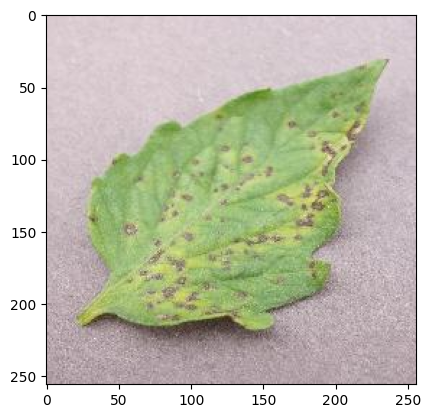

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Pre-Processing test data same as train data.
img_width = 256
img_height = 256

from keras.preprocessing import image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

result = model.predict([prepare('/content/drive/My Drive/Colab Notebooks/testing/Septoria_leaf_spot/Septoria leaf spot_210.jpg')])
#classes = np.round(result).astype(int)
disease = image.load_img('/content/drive/My Drive/Colab Notebooks/testing/Septoria_leaf_spot/Septoria leaf spot_210.jpg')
plt.imshow(disease)
res = np.argmax(result)
print (Classes[(res)])

**Confusion Matrix**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
y_test = test_generator.classes

# predicting our model with test dataset i.e. unseen dataset
pred = model.predict(test_generator, test_samples//batch_size+1,verbose=1,).argmax(axis=1)
#print(y_test)
print(pred)
#Classification report of every label
print(classification_report(y_test,pred, target_names = Classes))

16/16 [==============================] - 2s 95ms/step
[0 0 0 8 0 9 0 1 0 6 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 5 1 1 8 3 1 0 1 1 1 1 1 1 1 1 1 6 1 1 8 3 1 1 1 1 1 1 9 1 1 0 8 1 1 1 1
 1 8 0 1 1 1 1 1 6 1 1 1 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 6 3 8 3 3 3 1 3 3 3 1 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 5 6 4 4 4 4 4 4 4 4 6 4 4 4 7 4 4 4 4 4 4 4 4 5 5 5
 5 5 8 5 5 5 8 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 8 6 6 6 6
 6 6 4 6 6 6 1 6 6 6 1 6 6 6 6 5 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 7
 7 8 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 8 8 7 5 5 7 8 7 7 7 7 7 7 7 7 8 2 7
 7 8 7 7 8 7 7 7 7 8 8 8 7 7 5 7 7 2 8 8 2 2 8 8 8 8 7 8 8 8 8 8 8 8 8 8 8
 2 8 8 8 8 2 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 2 8 1 2 2 8 8 2 2 8
 9 7 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# get true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator,
                       steps = test_generator.samples // batch_size + 1,
                       verbose = 1).argmax(axis = 1)

# Define class names (replace with your actual class names)
class_names = ['Bacteria_spot', 'Early_blight', 'Healthy', 'Late_blight',
               'Leaf_mold', 'Mosaic_virus', 'Septoria_leaf_spot', 'Spider_mites', 'Target_spot', 'Yellow_leaf_curl']

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate sensitivity and specificity for each class
sensitivity = []
specificity = []
for i in range(len(class_names)):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - TP - FN - FP

    sensitivity.append(TP / (TP + FN))
    specificity.append(TN / (TN + FP))

# Find the longest class name length to align output
max_name_length = max(len(name) for name in class_names)

# print sensitivity and specificity for each class using target names
for i in range(len(class_names)):
    name = class_names[i].ljust(max_name_length)
    print(f"{name}: sensitivity = {sensitivity[i]:.2f}, specificity = {specificity[i]:.2f}")

16/16 [==============================] - 2s 115ms/step
Bacteria_spot     : sensitivity = 0.88, specificity = 0.98
Early_blight      : sensitivity = 0.64, specificity = 0.98
Healthy           : sensitivity = 1.00, specificity = 0.95
Late_blight       : sensitivity = 0.84, specificity = 0.99
Leaf_mold         : sensitivity = 0.86, specificity = 0.99
Mosaic_virus      : sensitivity = 0.75, specificity = 0.99
Septoria_leaf_spot: sensitivity = 0.46, specificity = 1.00
Spider_mites      : sensitivity = 0.93, specificity = 0.89
Target_spot       : sensitivity = 0.21, specificity = 0.98
Yellow_leaf_curl  : sensitivity = 0.91, specificity = 0.98


**Prediction Accuracy**

In [ ]:
#Total number of wrong prediction from our test dataset.
correct = 0
incorrect = 0
for i in range(len(y_test)):
  if y_test[i] != pred[i]:
    incorrect += 1
  else:
    correct += 1
print('Total number of test cases', ((len(y_test))))
print('Number of correct predictions', correct)
print('Number of incorrect predictions', incorrect)

Total number of test cases 500
Number of correct predictions 426
Number of incorrect predictions 74


**Plot Confusion Matrix**

<Axes: title={'center': 'Confusion Matrix of the Tomatoes Leaf Disease Prediction'}>

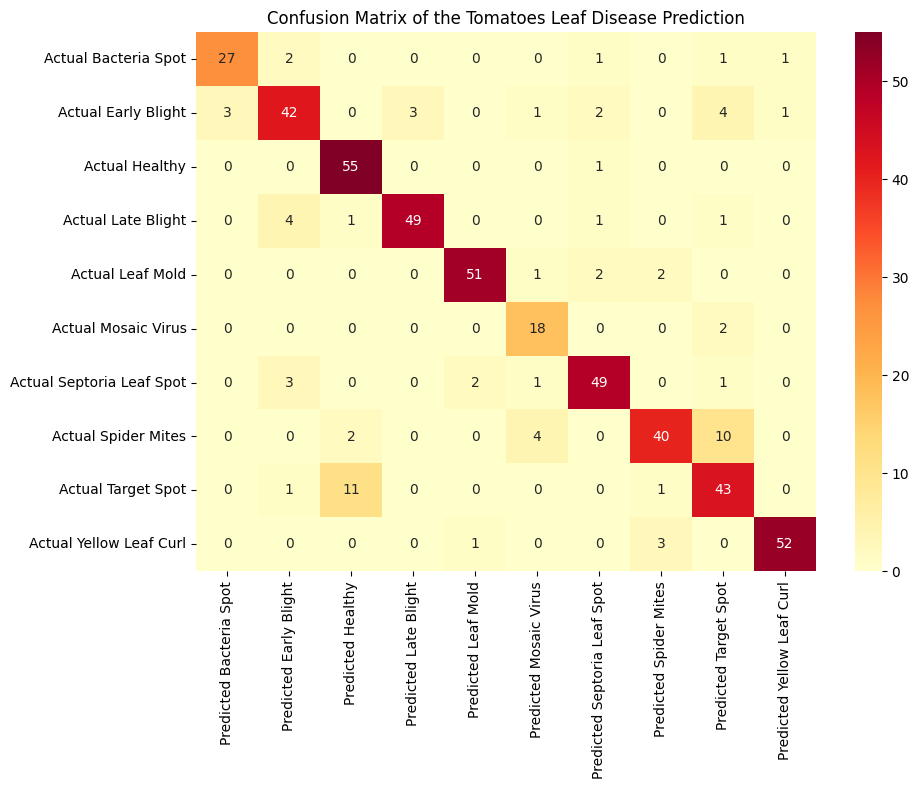

In [ ]:
import pandas as pd
import seaborn as sn

conf_mat = pd.DataFrame(confusion_matrix(y_test, pred),
                      columns = ["Predicted Bacteria Spot", "Predicted Early Blight", "Predicted Healthy",
                                 "Predicted Late Blight", "Predicted Leaf Mold", "Predicted Mosaic Virus",
                                 "Predicted Septoria Leaf Spot", "Predicted Spider Mites",
                                 "Predicted Target Spot", "Predicted Yellow Leaf Curl"],
                      index = ["Actual Bacteria Spot", "Actual Early Blight", "Actual Healthy",
                               "Actual Late Blight", "Actual Leaf Mold", "Actual Mosaic Virus",
                               "Actual Septoria Leaf Spot", "Actual Spider Mites",
                               "Actual Target Spot", "Actual Yellow Leaf Curl"])
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix of the Tomatoes Leaf Disease Prediction')
sn.heatmap(conf_mat, fmt = "d", cmap = "YlOrRd", annot = True)